# **Classification de tweets basée sur le transfert learning**

# Imports Packages

In [56]:
# Miscelaneous
import os
import sys
import re
import emoji
from string import punctuation
from unidecode import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')

# Keras
from keras.optimizers import Adam, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import (Dense,
                          Flatten,
                          LSTM,
                          GRU,
                          Dropout,
                          Input)
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as B

# SKLearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import shuffle

# Gensim
from gensim.models import KeyedVectors

# Mac Bug
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load Data

In [57]:
path = '../data/'
path_test = '../test/'
path_word2vec = '../word2vec/'
path_models = '../models/'

word2vec_google = path_word2vec + 'GoogleNews-vectors-negative300.bin'
emoji_path = path_word2vec + 'Emoji_Sentiment_Data_v1.0.csv'

train_3_path = path + 'data3.csv'
train_7_path = path + 'data7.csv'

In [58]:
# Loading Data Set 3 Classes
train_3_data = pd.read_csv(train_3_path, sep='\t', names=['text', 'class'])
display(train_3_data.head())
print(train_3_data.shape)

,text,class
0,Won the match #getin . Plus\u002c tomorrow is ...,0
1,Some areas of New England could see the first ...,0
2,@francesco_con40 2nd worst QB. DEFINITELY Tony...,-1
3,#Thailand Washington - US President Barack Oba...,0
4,Did y\u2019all hear what Tony Romo dressed up ...,0


(51353, 2)


In [59]:
# Loading Data Set 3 Classes
train_7_data = pd.read_csv(train_7_path, sep='\t', names=['text', 'class'])
display(train_7_data.head())
print(train_7_data.shape)

,text,class
0,@liamch88 yeah! :) playing well,0
1,At least I don't have a guy trying to discoura...,0
2,UPLIFT: If you're still discouraged it means y...,0
3,"...at your age, the heyday in the blood is tam...",0
4,i was so embarrassed when she saw us i was lik...,-2


(3260, 2)


# Preprocessing

In [60]:
emoji_df = pd.read_csv(emoji_path)
emoji_dict = {}
for index, row in emoji_df.iterrows():
    emoji_dict[row['Emoji']] = row['Unicode name'].lower()
display(emoji_df.head())
print(emoji_df.shape)

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons


(969, 9)


In [61]:
smileys = {
  ":‑)": "smiley",
  ":-]": "smiley",
  ":-3": "smiley",
  ":->": "smiley",
  "8-)": "smiley",
  ":-}": "smiley",
  ":)": "smiley",
  ":]": "smiley",
  ":3": "smiley",
  ":>": "smiley",
  "8)": "smiley",
  ":}": "smiley",
  ":o)": "smiley",
  ":c)": "smiley",
  ":^)": "smiley",
  "=]": "smiley",
  "=)": "smiley",
  ":-))": "smiley",
  ":‑D": "smiley",
  "8‑D": "smiley",
  "x‑D": "smiley",
  "X‑D": "smiley",
  ":D": "smiley",
  "8D": "smiley",
  "xD": "smiley",
  "XD": "smiley",
  ">:D": "smiley",
  ":‑(": "sad",
  ":‑c": "sad",
  ":‑<": "sad",
  ":‑[": "sad",
  ":(": "sad",
  ":c": "sad",
  ":<": "sad",
  ":[": "sad",
  ":-||": "sad",
  ">:[": "sad",
  ":{": "sad",
  ":@": "sad",
  ">:(": "sad",
  ":'‑(": "sad",
  ":'(": "sad",
  ":‑P": "playful",
  "X‑P": "playful",
  "x‑p": "playful",
  ":‑p": "playful",
  ":‑Þ": "playful",
  ":‑þ": "playful",
  ":‑b": "playful",
  ":P": "playful",
  "XP": "playful",
  "xp": "playful",
  ":p": "playful",
  ":Þ": "playful",
  ":þ": "playful",
  ":b": "playful",
  "<3": "love"
}

contractions = {
  "ain't": "is not",
  "amn't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "'cause": "because",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "could've": "could have",
  "daren't": "dare not",
  "daresn't": "dare not",
  "dasn't": "dare not",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "e'er": "ever",
  "em": "them",
  "everyone's": "everyone is",
  "finna": "fixing to",
  "gimme": "give me",
  "gonna": "going to",
  "gon't": "go not",
  "gotta": "got to",
  "hadn't": "had not",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'll": "he will",
  "he's": "he is",
  "he've": "he have",
  "how'd": "how would",
  "how'll": "how will",
  "how're": "how are",
  "how's": "how is",
  "I'd": "I would",
  "I'll": "I will",
  "I'm": "I am",
  "i'm": "I am",
  "I'm'a": "I am about to",
  "I'm'o": "I am going to",
  "isn't": "is not",
  "it'd": "it would",
  "it'll": "it will",
  "it's": "it is",
  "I've": "I have",
  "kinda": "kind of",
  "let's": "let us",
  "mayn't": "may not",
  "may've": "may have",
  "mightn't": "might not",
  "might've": "might have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "must've": "must have",
  "needn't": "need not",
  "ne'er": "never",
  "o'": "of",
  "o'er": "over",
  "ol'": "old",
  "oughtn't": "ought not",
  "shalln't": "shall not",
  "shan't": "shall not",
  "she'd": "she would",
  "she'll": "she will",
  "she's": "she is",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "should've": "should have",
  "somebody's": "somebody is",
  "someone's": "someone is",
  "something's": "something is",
  "that'd": "that would",
  "that'll": "that will",
  "that're": "that are",
  "that's": "that is",
  "there'd": "there would",
  "there'll": "there will",
  "there're": "there are",
  "there's": "there is",
  "these're": "these are",
  "they'd": "they would",
  "they'll": "they will",
  "they're": "they are",
  "they've": "they have",
  "this's": "this is",
  "those're": "those are",
  "'tis": "it is",
  "'twas": "it was",
  "wanna": "want to",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we're": "we are",
  "weren't": "were not",
  "we've": "we have",
  "what'd": "what did",
  "what'll": "what will",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "where'd": "where did",
  "where're": "where are",
  "where's": "where is",
  "where've": "where have",
  "which's": "which is",
  "who'd": "who would",
  "who'd've": "who would have",
  "who'll": "who will",
  "who're": "who are",
  "who's": "who is",
  "who've": "who have",
  "why'd": "why did",
  "why're": "why are",
  "why's": "why is",
  "won't": "will not",
  "wouldn't": "would not",
  "would've": "would have",
  "y'all": "you all",
  "you'd": "you would",
  "you'll": "you will",
  "you're": "you are",
  "you've": "you have",
  "Whatcha": "What are you",
  "luv": "love",
  "sux": "sucks"
}

characters = ['\'', '"', '_', '-', '.', ';', ':', '?', '!', '#']

In [62]:
tknzr = TweetTokenizer()
notstopwords = set(('not', 'no'))
my_stopwords = set(stopwords.words('english')) - notstopwords

def standardization(tweet):
    # Tokenizer
    tknzr = TweetTokenizer()
    tweet = tknzr.tokenize(tweet)
    
    # Smileys & Contraction
    tweet = [smileys[i] if i in smileys else i for i in tweet]
    tweet = [emoji_dict[i] if i in emoji_dict else i for i in tweet]
    tweet = [contractions[i] if i in contractions else i for i in tweet]
    tweet = ' '.join(tweet)
    
    # Hashtag & Tag & URL & Unicode
    tweet = re.sub(r'(\\u[0-9A-Fa-f]+)', ' ', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"@\w+", '', tweet)
    # Trying not removing hashtag.
    #tweet = re.sub(r"#\w+", '', tweet)
    for ch in characters:
        tweet = tweet.replace(ch, ' ')
        
    # Lower
    tweet = tweet.lower()

    # Tokenizing & Stopwords
    tweet = tknzr.tokenize(tweet)
    tweet = [i for i in tweet if (i not in my_stopwords) and (i not in punctuation)]
    
    # Join
    tweet = ' '.join(tweet)
    
    return tweet

In [63]:
# Applying Standardization
train_3_data['text'] = train_3_data['text'].apply(standardization)
train_7_data['text'] = train_7_data['text'].apply(standardization)

In [64]:
# Fitting Tokenizer & Calculating Max Seq Length
all_tweets = train_3_data['text'].append(train_7_data['text'])
MAX_SEQUENCE_LENGTH = int(0.7 * all_tweets.apply(lambda x: len(x)).max())
tokenizer = Tokenizer(filters=' ')
tokenizer.fit_on_texts(all_tweets)
word_index = tokenizer.word_index

In [65]:
# Applying Text To Sequences
train_3_data['text'] = tokenizer.texts_to_sequences(train_3_data['text'])
train_7_data['text'] = tokenizer.texts_to_sequences(train_7_data['text'])

In [66]:
# Applying Padding
train_3_data['text'] = train_3_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])
train_7_data['text'] = train_7_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])

In [67]:
class DataGenerator:
    def __init__(self, df, word2vec, max_size, nb_classes, batch_size):
        self.df = df
        self.word2vec = word2vec
        self.max_size = max_size
        self.nb_classes = nb_classes
        self.data_set_size = len(df)
        self.batch_size = batch_size
        self.step = len(df) // batch_size + (1 if self.data_set_size % self.batch_size else 0)

    def getXAt(self, index):
        return np.array(self.df.iloc[index]['text'])

    def getYAt(self, index):
        res = np.zeros(self.nb_classes)
        res[self.nb_classes // 2 + self.df.iloc[index]['class']] = 1
        return res

    def getWeights(self):
        WEIGHTS = {}
        nb_classes = []
        for i in range(self.nb_classes):
            nb_classes.append(self.df[self.df['class'] == (i - self.nb_classes // 2)].shape[0])
        for i in range(self.nb_classes):
            WEIGHTS[i] = max(nb_classes) / nb_classes[i]
        return WEIGHTS

    def getGenerator(self):
        while True:
            for idx in range(self.step):
                batch_x = np.array([self.getXAt(index) for index in range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.data_set_size))])
                batch_y = np.array([self.getYAt(index) for index in range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.data_set_size))])
                yield batch_x, batch_y

    def getInputGenerator(self):
        for idx in range(self.step):
            batch_x = [self.getXAt(index) for index in range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.data_set_size))]
            yield np.array(batch_x)

In [68]:
# Word2Vec
EMBEDDING_DIM = 300
word2vec = KeyedVectors.load_word2vec_format(word2vec_google, binary=True)

In [69]:
# Default Vector
default_vector = (np.random.rand(EMBEDDING_DIM) * 2.0) - 1
default_vector /= np.linalg.norm(default_vector)

# Number of words
nb_words = len(word_index) + 1

# Embeddings Matrix
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
cpt = 0
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        cpt += 1
    else:
        embedding_matrix[i] = default_vector
print('Embedding Matrix is {:.2f}% full'.format(100 * cpt / len(embedding_matrix)))

Embedding Matrix is 58.49% full


# Custom Metrics

In [70]:
def distance(y_true, y_pred):
    return B.square(B.argmax(y_true) - B.argmax(y_pred))

# Training

In [74]:
# Parameters
BATCH_SIZE = 16
LEARNING_RATE = 0.01
EPOCHS = 32
PATIENCE = 2
LR_PATIENCE = 2
train_df, val_df = train_test_split(train_3_data, test_size=0.2, random_state=0)
val_df, test_df = train_test_split(val_df, test_size=0.3, random_state=0)
print(train_df.shape, val_df.shape, test_df.shape)
TRAINING_GENERATOR = DataGenerator(train_df, word2vec, MAX_SEQUENCE_LENGTH, 3, BATCH_SIZE)
VALIDATION_GENERATOR = DataGenerator(val_df, word2vec, MAX_SEQUENCE_LENGTH, 3, BATCH_SIZE)
WEIGHTS = TRAINING_GENERATOR.getWeights()
STEPS_PER_EPOCH = TRAINING_GENERATOR.step
VALIDATION_STEPS = VALIDATION_GENERATOR.step
print(WEIGHTS)

(41082, 2) (7189, 2) (3082, 2)
{0: 2.870425167419405, 1: 1.0, 2: 1.1356130622304375}


In [75]:
# Model Structure
model1 = Sequential()
model1.add(Embedding(nb_words,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False, name='embedding_layer_model_1'
                    ))
model1.add(GRU(64))
model1.add(Dense(128, activation='relu', name='dense_1_model_1'))
model1.add(Dropout(0.1, name='drop_out_1_model_1'))
model1.add(Dense(3, activation='softmax', name='output_layer_model_1'))

# Summary
model1.summary()

# Callbacks, Optimizers & Compile
optimizer = SGD(lr=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', distance]
)
Callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=LR_PATIENCE, verbose=True),
             EarlyStopping(patience=PATIENCE, monitor='val_accuracy')]

# Training
history = model1.fit(TRAINING_GENERATOR.getGenerator(),
                     validation_data=VALIDATION_GENERATOR.getGenerator(),
                     epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                     validation_steps=VALIDATION_STEPS,
                     callbacks=Callbacks,
                     verbose=True)
                     #class_weight=WEIGHTS)

# Saving the Model
model1.save("{}{}".format(path_models, "model1.h5"))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer_model_1 (Emb (None, 211, 300)          13813500  
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_1_model_1 (Dense)      (None, 128)               8320      
_________________________________________________________________
drop_out_1_model_1 (Dropout) (None, 128)               0         
_________________________________________________________________
output_layer_model_1 (Dense) (None, 3)                 387       
Total params: 13,892,287
Trainable params: 78,787
Non-trainable params: 13,813,500
_________________________________________________________________
Epoch 1/32
2568/2568 [==============================] - 94s 36ms/step - loss: 0.8577 - accuracy: 0.5824

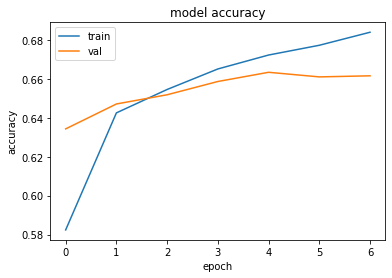

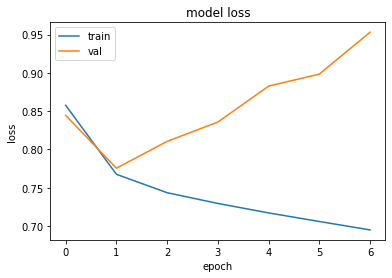

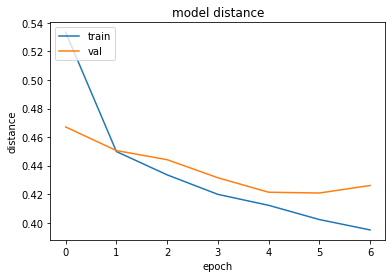

193/193 [==============================] - 2s 9ms/step
[0.7225831151008606, 0.672939658164978, 0.41855937242507935]
[[240 195  50]
 [125 997 267]
 [ 44 327 837]]


(array([-1,  0,  1]), array([ 409, 1519, 1154]))

In [76]:
# Plotting hist acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting hist loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting distance loss
plt.plot(history.history['distance'])
plt.plot(history.history['val_distance'])
plt.title('model distance')
plt.ylabel('distance')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Testing
TEST_GENERATOR = DataGenerator(test_df, word2vec, MAX_SEQUENCE_LENGTH, 3, BATCH_SIZE)
print(model1.evaluate(TEST_GENERATOR.getGenerator(), verbose=True, steps=TEST_GENERATOR.step))
y_pred = np.argmax(model1.predict(TEST_GENERATOR.getInputGenerator(), steps=TEST_GENERATOR.step), axis=1) - 1
y_true = test_df['class']
print(confusion_matrix(y_true, y_pred))
np.unique(y_pred, return_counts=True)

# Best was [0.9722, 0.6535, 0.4334]

In [77]:
# Parameters
LEARNING_RATE = 0.01
BATCH_SIZE = 16
EPOCHS = 256
PATIENCE = 64
LR_PATIENCE = 8
train_df, val_df = train_test_split(train_7_data, test_size=0.2, random_state=0)
val_df, test_df = train_test_split(val_df, test_size=0.3, random_state=0)
TRAINING_GENERATOR = DataGenerator(train_df, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
VALIDATION_GENERATOR = DataGenerator(val_df, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
WEIGHTS = TRAINING_GENERATOR.getWeights()
print(WEIGHTS)
STEPS_PER_EPOCH = TRAINING_GENERATOR.step
VALIDATION_STEPS = VALIDATION_GENERATOR.step

{0: 2.3289473684210527, 1: 1.2665474060822899, 2: 3.89010989010989, 3: 1.0, 4: 1.9887640449438202, 5: 3.420289855072464, 6: 2.4246575342465753}


In [79]:
# Model Structure
dependencies = {'distance': distance}
model2 = load_model("{}{}".format(path_models, "best_model1.h5"), custom_objects=dependencies)
model2.pop()

for layer in model2.layers:
    layer.trainable = False

model2.add(Dense(64, activation='relu', name='dense_1_model_2'))
model2.add(Dense(7, activation='softmax', name='output_layer_model_2'))

# Summary
model2.summary()

# Callbacks & Optimizer
optimizer = SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model2.compile(
    loss='categorical_crossentropy', #kullback_leibler_divergence
    optimizer=optimizer,
    metrics=['accuracy', distance]
)
Callbacks=[EarlyStopping(patience=PATIENCE, monitor='val_accuracy', restore_best_weights=False),
           ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=LR_PATIENCE, verbose=True)]

# Training
history = model2.fit(TRAINING_GENERATOR.getGenerator(),
                     validation_data=VALIDATION_GENERATOR.getGenerator(),
                     epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                     validation_steps=VALIDATION_STEPS,
                     callbacks=Callbacks,
                     verbose=True,
                     class_weight=WEIGHTS)

# Saving the Model
model2.save("{}{}".format(path_models, "model2.h5"))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer_model_1 (Emb (None, 211, 300)          13813500  
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_1_model_1 (Dense)      (None, 128)               8320      
_________________________________________________________________
drop_out_1_model_1 (Dropout) (None, 128)               0         
_________________________________________________________________
dense_1_model_2 (Dense)      (None, 64)                8256      
_________________________________________________________________
output_layer_model_2 (Dense) (None, 7)                 455       
Total params: 13,970,687
Trainable params: 78,787
Non-trainable params: 13,891,900
_____________________________________

/home/vincent/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/256
163/163 [==============================] - 2s 12ms/step - loss: 3.0552 - accuracy: 0.2780 - distance: 2.7814 - val_loss: 1.3867 - val_accuracy: 0.3618 - val_distance: 2.4737
Epoch 2/256
163/163 [==============================] - 2s 11ms/step - loss: 2.8687 - accuracy: 0.3301 - distance: 2.1434 - val_loss: 1.3550 - val_accuracy: 0.3816 - val_distance: 2.3904
Epoch 3/256
163/163 [==============================] - 2s 11ms/step - loss: 2.8199 - accuracy: 0.3347 - distance: 2.1361 - val_loss: 1.3553 - val_accuracy: 0.3684 - val_distance: 2.4101
Epoch 4/256
163/163 [==============================] - 2s 11ms/step - loss: 2.7960 - accuracy: 0.3455 - distance: 2.0729 - val_loss: 1.3373 - val_accuracy: 0.3706 - val_distance: 2.3333
Epoch 5/256
163/163 [==============================] - 2s 11ms/step - loss: 2.7702 - accuracy: 0.3608 - distance: 2.0299 - val_loss: 1.3425 - val_accuracy: 0.3882 - val_distance: 2.3465
Epoch 6/256
163/163 [==============================] - 2s 11ms/step - 

Epoch 44/256
163/163 [==============================] - 2s 11ms/step - loss: 2.0941 - accuracy: 0.5061 - distance: 1.7266 - val_loss: 1.2378 - val_accuracy: 0.4254 - val_distance: 2.0921
Epoch 45/256
163/163 [==============================] - 2s 11ms/step - loss: 2.0937 - accuracy: 0.5165 - distance: 1.7040 - val_loss: 1.2713 - val_accuracy: 0.4452 - val_distance: 2.1294
Epoch 46/256
163/163 [==============================] - 2s 11ms/step - loss: 2.0760 - accuracy: 0.5119 - distance: 1.6791 - val_loss: 1.2392 - val_accuracy: 0.4320 - val_distance: 2.0811

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 47/256
163/163 [==============================] - 2s 11ms/step - loss: 2.0683 - accuracy: 0.5234 - distance: 1.6806 - val_loss: 1.2816 - val_accuracy: 0.4430 - val_distance: 2.1009
Epoch 48/256
163/163 [==============================] - 2s 11ms/step - loss: 2.0677 - accuracy: 0.5196 - distance: 1.7412 - val_loss: 1.2453 - val_accuracy: 0.4474 - val_d

163/163 [==============================] - 2s 11ms/step - loss: 1.9140 - accuracy: 0.5587 - distance: 1.6039 - val_loss: 1.2643 - val_accuracy: 0.4649 - val_distance: 2.0548
Epoch 87/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9151 - accuracy: 0.5571 - distance: 1.5683 - val_loss: 1.2722 - val_accuracy: 0.4583 - val_distance: 2.0768

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 88/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9380 - accuracy: 0.5464 - distance: 1.5824 - val_loss: 1.2707 - val_accuracy: 0.4605 - val_distance: 2.0987
Epoch 89/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9357 - accuracy: 0.5583 - distance: 1.5928 - val_loss: 1.2711 - val_accuracy: 0.4627 - val_distance: 2.0855
Epoch 90/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9256 - accuracy: 0.5660 - distance: 1.5771 - val_loss: 1.2679 - val_accuracy: 0.4627 - val_distance: 2.0

163/163 [==============================] - 2s 11ms/step - loss: 1.9351 - accuracy: 0.5399 - distance: 1.6039 - val_loss: 1.2696 - val_accuracy: 0.4649 - val_distance: 2.0833

Epoch 00127: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
Epoch 128/256
163/163 [==============================] - 2s 11ms/step - loss: 1.8830 - accuracy: 0.5541 - distance: 1.5759 - val_loss: 1.2693 - val_accuracy: 0.4649 - val_distance: 2.0833
Epoch 129/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9139 - accuracy: 0.5706 - distance: 1.5683 - val_loss: 1.2693 - val_accuracy: 0.4649 - val_distance: 2.0833
Epoch 130/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9063 - accuracy: 0.5613 - distance: 1.5322 - val_loss: 1.2693 - val_accuracy: 0.4649 - val_distance: 2.0833
Epoch 131/256
163/163 [==============================] - 2s 11ms/step - loss: 1.9408 - accuracy: 0.5472 - distance: 1.5809 - val_loss: 1.2695 - val_accuracy: 0.4649 - val_distance: 

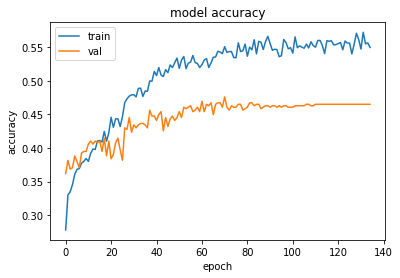

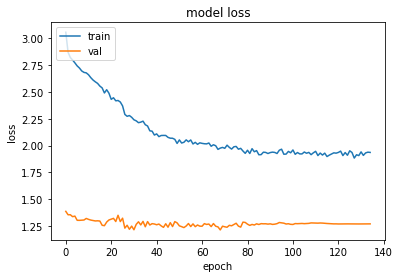

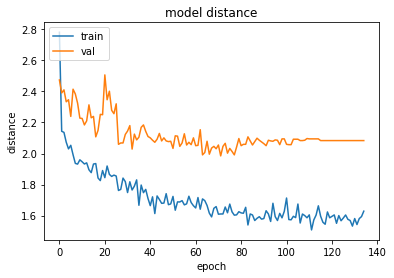

13/13 [==============================] - 0s 12ms/step
[0.6320037841796875, 0.45408162474632263, 1.8163264989852905]
[[16  2  5  0  0  1  0]
 [ 5 18  5  5  0  4  0]
 [ 1  1 11  0  0  0  0]
 [ 1  8  7 17  8  4  3]
 [ 1  1  0  7 13  3  7]
 [ 0  0  0  2  3  2 12]
 [ 0  0  0  1  2  8 12]]


(array([-3, -2, -1,  0,  1,  2,  3]), array([24, 30, 28, 32, 26, 22, 34]))

In [80]:
# Plotting hist acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting hist loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting distance loss
plt.plot(history.history['distance'])
plt.plot(history.history['val_distance'])
plt.title('model distance')
plt.ylabel('distance')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Testing the model
TEST_GENERATOR = DataGenerator(test_df, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
print(model2.evaluate(TEST_GENERATOR.getGenerator(), verbose=True, steps=TEST_GENERATOR.step))
y_pred = np.argmax(model2.predict(TEST_GENERATOR.getInputGenerator(), steps=TEST_GENERATOR.step), axis=1) - 3
y_true = np.array(test_df['class'])
print(confusion_matrix(y_true, y_pred))
np.unique(y_pred, return_counts=True)

# Best was [0.9267, 0.7091, 1.8418]

# Prediction

In [82]:
# Loading Data Set 7 Classes
predict_7_data = pd.read_csv(path + 'submission.csv', encoding='utf-8', sep='\t')

# Rename Ugly Col Names
predict_7_data = predict_7_data.rename(columns={"Tweet": "text", "sentiment": "class"})

# Display
display(predict_7_data.head())
print(predict_7_data.shape)

# Preprocessing
tmp = predict_7_data['text'].copy()
predict_7_data['text'] = predict_7_data['text'].apply(standardization)
predict_7_data['text'] = tokenizer.texts_to_sequences(predict_7_data['text'])
predict_7_data['text'] = predict_7_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])

# Display
display(predict_7_data.head())
print(predict_7_data.shape)

# Loading
dependencies = {'distance': distance}
model2 = load_model("{}{}".format(path_models, "best_model2.h5"), custom_objects=dependencies)

# Predicting
PREDICT_GENERATOR = DataGenerator(predict_7_data, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
y_pred = np.argmax(model2.predict(PREDICT_GENERATOR.getInputGenerator(), steps=PREDICT_GENERATOR.step), axis=1) - 3
predict_7_data['class'] = y_pred
predict_7_data['text'] = tmp

# Display Results
display(predict_7_data.head())
with open(path_test + 'result.csv', "w") as f:
    predict_7_data.to_csv(f, sep='\t', index=False)

,ID,text,Affect Dimension,class
0,2018-En-01964,Gm and have a #Tuesday!,valence,NONE
1,2018-En-01539,@realDonaldTrump But you have a lot of time fo...,valence,NONE
2,2018-En-04235,I graduated yesterday and already had 8 family...,valence,NONE
3,2018-En-03711,@jaimitoelcrack7 Seriously...I've been sitting...,valence,NONE
4,2018-En-01177,Whether my glass is half empty or its half ful...,valence,NONE


(937, 4)


,ID,text,Affect Dimension,class
0,2018-En-01964,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",valence,NONE
1,2018-En-01539,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",valence,NONE
2,2018-En-04235,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",valence,NONE
3,2018-En-03711,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",valence,NONE
4,2018-En-01177,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",valence,NONE


(937, 4)


,ID,text,Affect Dimension,class
0,2018-En-01964,Gm and have a #Tuesday!,valence,1
1,2018-En-01539,@realDonaldTrump But you have a lot of time fo...,valence,-3
2,2018-En-04235,I graduated yesterday and already had 8 family...,valence,-1
3,2018-En-03711,@jaimitoelcrack7 Seriously...I've been sitting...,valence,3
4,2018-En-01177,Whether my glass is half empty or its half ful...,valence,1
